# Time series with Prophet

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
 
%matplotlib inline
 
# import tpot
%config InlineBackend.figure_format = 'png' 
plt.style.use(style='fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

### Load Data

In [2]:
df = pd.read_csv('../data/monthly_sales.csv', index_col='date', parse_dates=True)

For prophet to work, we need to change the names of these columns to 'ds' and 'y', so lets just create a new dataframe and keep our old one handy (you'll see why later). The new dataframe will initially be created with an integer index so we can rename the columns

In [3]:
dfcopy = df.copy()

In [4]:
df = df.reset_index()
df.columns = ['ds','y']

In [5]:
df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [6]:
df.head(5)

,ds,y
0,2009-10-01,338630
1,2009-11-01,339386
2,2009-12-01,400264
3,2010-01-01,314640
4,2010-02-01,311022


In [7]:
df.describe()

,y
count,72.000000
mean,401710.138889
std,39999.439045
min,311022.000000
25%,374655.750000
50%,398296.500000
75%,432892.500000
max,501232.000000


* So we have 72 months worth of sales data at our disposal, with the mean monthly sales being \\$401k and the median lying at \$398k
* Looks like our worst month was \$311k which happened in the beginning of our data and the best month was \$501k which happened in December 2014
* Our range is from 2009-10-01 to 2015-09-01

### Exploratory Analysis

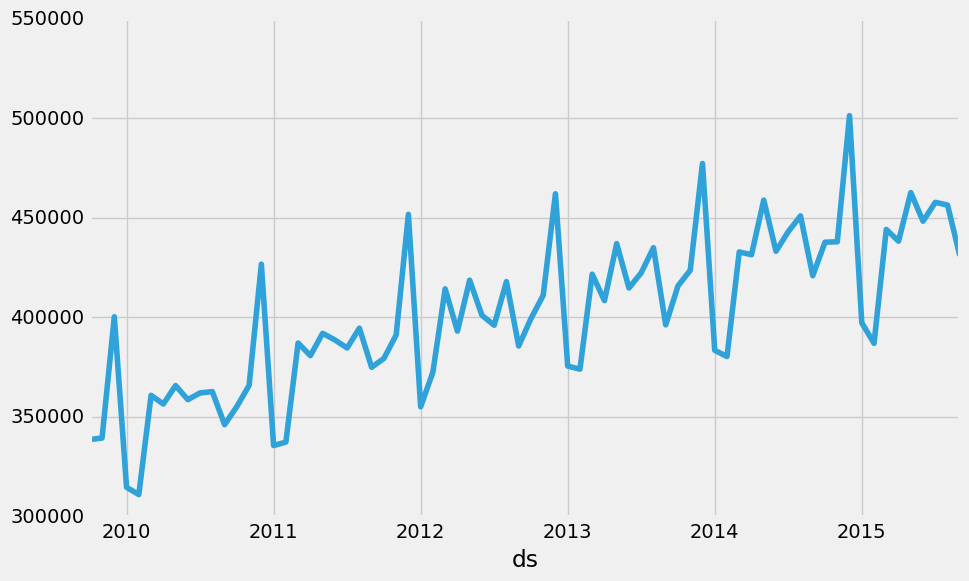

In [8]:
df.set_index('ds').y.plot()
plt.savefig('../figures/sales.png')

When working with time-series data, its good to take a look at the data to see if trends exist, if there are outliers, if it's stationary, etc etc.

Facebook prophet's example data uses the log-transform as a way to remove some of these anomolies, so we'll do the same. 

In [9]:
df['y'] = np.log(df['y'])

In [10]:
df.head(5)

,ds,y
0,2009-10-01,12.732663
1,2009-11-01,12.734893
2,2009-12-01,12.899880
3,2010-01-01,12.659184
4,2010-02-01,12.647619


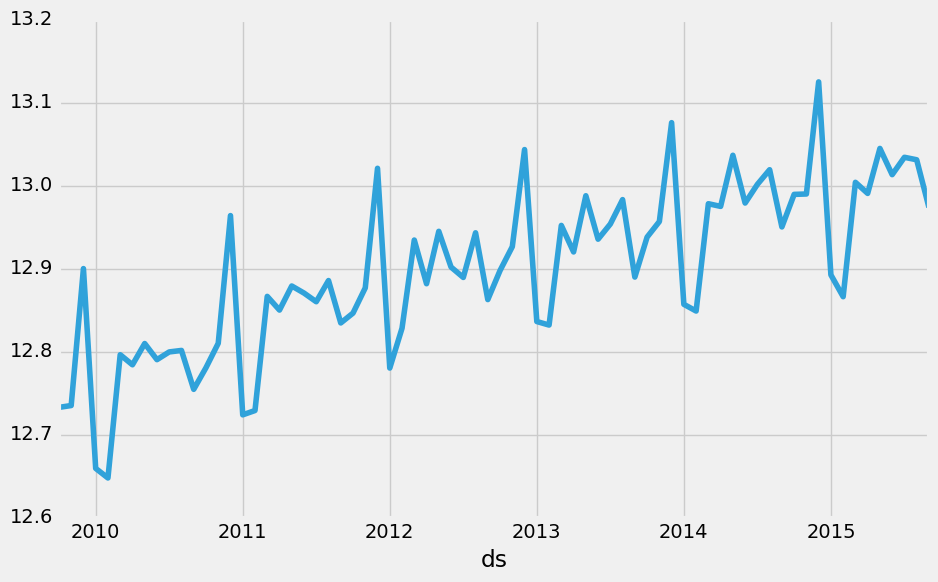

In [11]:
df.set_index('ds').y.plot()
plt.savefig('../figures/log_sales.png')

## Modeling with Prophet

In [12]:
model = Prophet()
model.fit(df)

So for this example, I want to forecast 2 years into the future. That means I'll create a future dataframe using Prophet with 24 (monthly) periods.


In [13]:
future = model.make_future_dataframe(periods=24, freq = 'm')
future.tail()

,ds
92,2017-05-31
93,2017-06-30
94,2017-07-31
95,2017-08-31
96,2017-09-30


To forecast this future data, we need to run it through Prophet's model.

In [14]:
forecast = model.predict(future)

In [15]:
forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
92,2017-05-31,1.295234,13.038949,0.024956,0.024956,12.751115,13.328132,12.774388,13.352970,0.011064,0.011064,0.011064,0.013892,0.013892,0.013892,0.024956,13.063905
93,2017-06-30,1.309116,13.040490,0.017360,0.017360,12.736152,13.348323,12.753335,13.365854,0.002113,0.002113,0.002113,0.015248,0.015248,0.015248,0.017360,13.057850
94,2017-07-31,1.323461,13.042081,0.030121,0.030121,12.716578,13.373303,12.746090,13.404600,-0.001753,-0.001753,-0.001753,0.031874,0.031874,0.031874,0.030121,13.072202
95,2017-08-31,1.337807,13.043672,-0.025671,-0.025671,12.698625,13.393837,12.675544,13.368244,0.008874,0.008874,0.008874,-0.034546,-0.034546,-0.034546,-0.025671,13.018001
96,2017-09-30,1.351689,13.045213,-0.018348,-0.018348,12.682873,13.415860,12.662880,13.399257,-0.006851,-0.006851,-0.006851,-0.011497,-0.011497,-0.011497,-0.018348,13.026865


### Let's dig a little deeper


We really only want to look at yhat, yhat_lower and yhat_upper, so we can do that with:

In [16]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
92,2017-05-31,13.063905,12.774388,13.352970
93,2017-06-30,13.057850,12.753335,13.365854
94,2017-07-31,13.072202,12.746090,13.404600
95,2017-08-31,13.018001,12.675544,13.368244
96,2017-09-30,13.026865,12.662880,13.399257


Remember it's still in log form, so if it doesn't look like it makes sense that's why. We'll switch it back at the end.

Let's plot our results

This Prophet plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

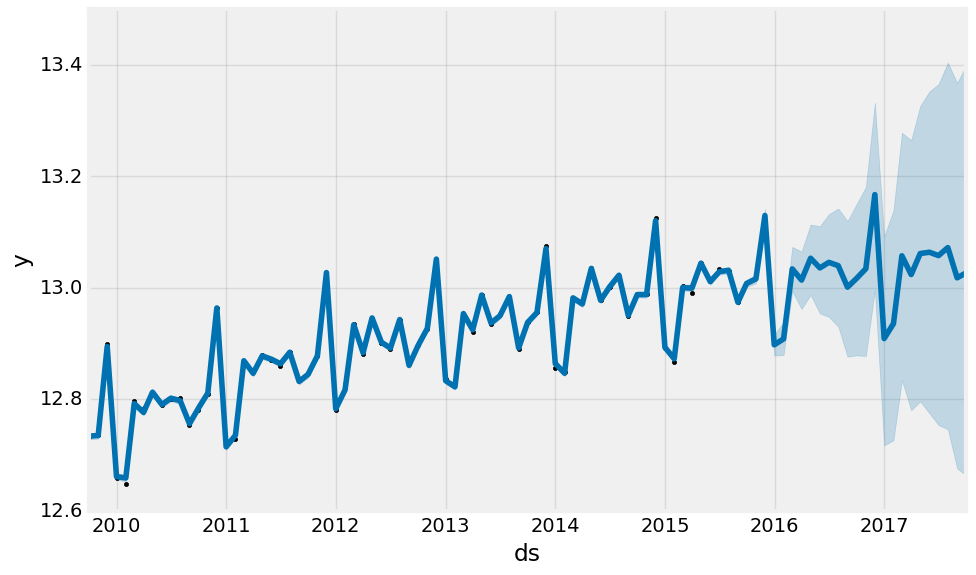

In [17]:
model.plot(forecast)
plt.savefig('../figures/sales_forecast.png')

If you like this type of plot, great, we'll keep it. Otherwise we can reconstruct our plot with our own tools

In [18]:
df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)

In [19]:
plot_df = dfcopy.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

In [20]:
plot_df.head()

,sales,yhat,yhat_lower,yhat_upper
2009-10-01,338630.0,12.733651,12.727715,12.738734
2009-11-01,339386.0,12.734660,12.729165,12.740304
2009-12-01,400264.0,12.894563,12.889380,12.900343
2010-01-01,314640.0,12.660891,12.654992,12.666383
2010-02-01,311022.0,12.658416,12.652802,12.663416


Okay so the above looks to be in different scales, let's rescale our yhat columns back to the original scale.


In [21]:
plot_df['yhat_rescaled'] = np.exp(plot_df['yhat'])

In [22]:
plot_df.head()

,sales,yhat,yhat_lower,yhat_upper,yhat_rescaled
2009-10-01,338630.0,12.733651,12.727715,12.738734,338964.534423
2009-11-01,339386.0,12.734660,12.729165,12.740304,339306.771794
2009-12-01,400264.0,12.894563,12.889380,12.900343,398141.648060
2010-01-01,314640.0,12.660891,12.654992,12.666383,315177.477081
2010-02-01,311022.0,12.658416,12.652802,12.663416,314398.176783


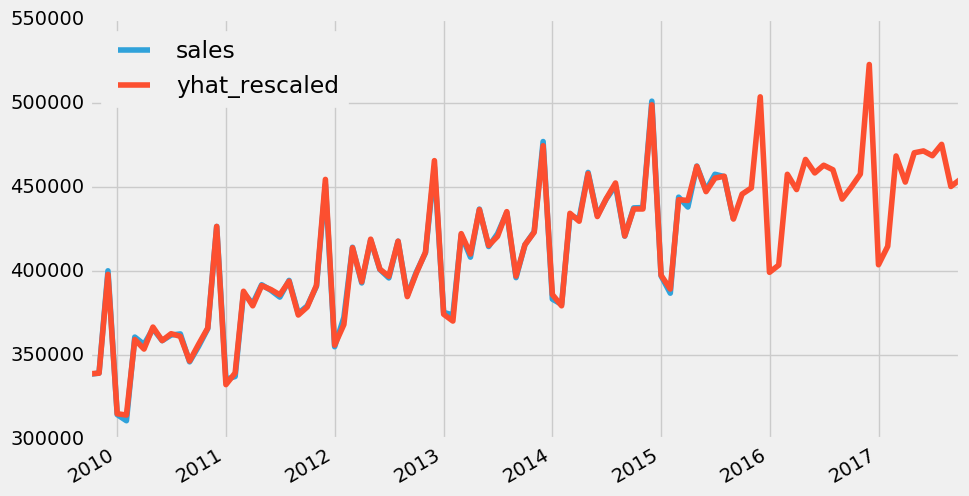

In [23]:
plot_df[['sales', 'yhat_rescaled']].plot()
plt.savefig('../figures/sales_forecast_2.png')

In [24]:
dfcopy.index = pd.to_datetime(dfcopy.index) #make sure our index as a datetime object
connect_date = dfcopy.index[-2]

Using the connect_date we can now grab only the model data that after that date (you'll see why in a minute). To do this, we'll mask the forecast data.

In [25]:
mask = (forecast.index > connect_date)
predict_df = forecast.loc[mask]

In [26]:
predict_df.head()

,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
ds,,,,,,,,,,,,,,,,
2015-09-01,1.000000,13.006197,-0.032206,-0.032206,13.006197,13.006197,12.968731,12.979489,0.002865,0.002865,0.002865,-0.035071,-0.035071,-0.035071,-0.032206,12.973991
2015-09-30,1.013420,13.007685,0.000146,0.000146,13.006570,13.008207,13.001887,13.014274,0.011064,0.011064,0.011064,-0.010917,-0.010917,-0.010917,0.000146,13.007832
2015-10-31,1.027765,13.009277,0.006741,0.006741,13.003935,13.014070,13.007880,13.023696,-0.006851,-0.006851,-0.006851,0.013592,0.013592,0.013592,0.006741,13.016018
2015-11-30,1.041647,13.010817,0.119134,0.119134,12.998984,13.021509,13.117427,13.141578,-0.001753,-0.001753,-0.001753,0.120887,0.120887,0.120887,0.119134,13.129951
2015-12-31,1.055993,13.012408,-0.114831,-0.114831,12.993394,13.030907,12.878462,12.916385,0.008874,0.008874,0.008874,-0.123705,-0.123705,-0.123705,-0.114831,12.897578


In [27]:
plot_df = dfcopy.join(predict_df[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
plot_df['yhat_scaled']=np.exp(plot_df['yhat'])

In [28]:
plot_df.head()

,sales,yhat,yhat_lower,yhat_upper,yhat_scaled
2009-10-01,338630.0,NaN,NaN,NaN,NaN
2009-11-01,339386.0,NaN,NaN,NaN,NaN
2009-12-01,400264.0,NaN,NaN,NaN,NaN
2010-01-01,314640.0,NaN,NaN,NaN,NaN
2010-02-01,311022.0,NaN,NaN,NaN,NaN


Okay so the NaN are normal since they aren't included in both dfs that we combined, however when we look at plot_df.tail() it'll be there

In [29]:
plot_df.tail()

,sales,yhat,yhat_lower,yhat_upper,yhat_scaled
2017-05-31,NaN,13.063905,12.774388,13.352970,471608.825245
2017-06-30,NaN,13.057850,12.753335,13.365854,468761.722729
2017-07-31,NaN,13.072202,12.746090,13.404600,475537.965759
2017-08-31,NaN,13.018001,12.675544,13.368244,450449.372071
2017-09-30,NaN,13.026865,12.662880,13.399257,454459.845513


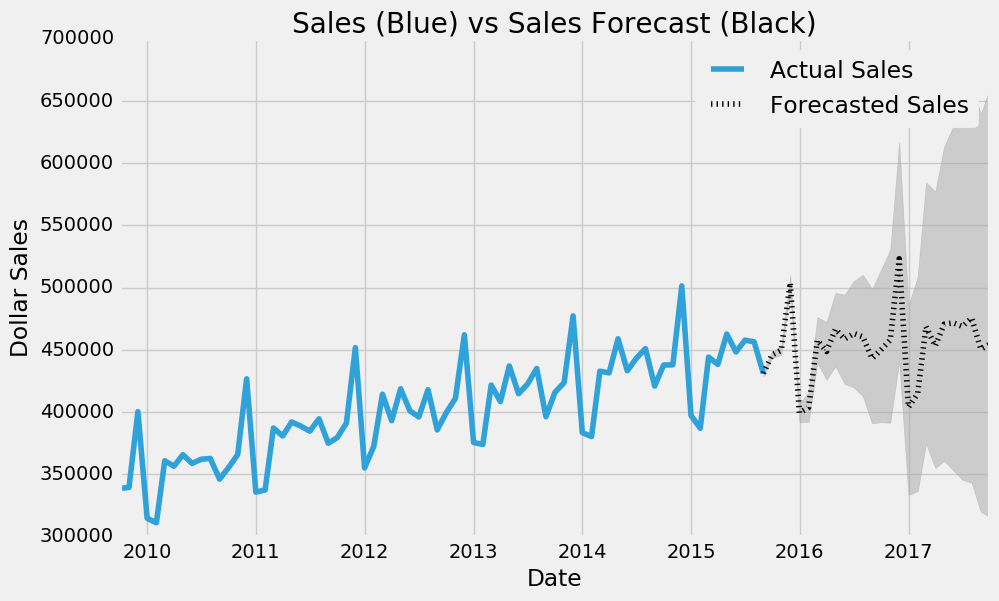

In [30]:
fig, ax1 = plt.subplots()
ax1.plot(plot_df.sales)
ax1.plot(plot_df.yhat_scaled, color='black', linestyle=':')
ax1.fill_between(plot_df.index, np.exp(plot_df['yhat_upper']), np.exp(plot_df['yhat_lower']), alpha=0.5, color='darkgray')
ax1.set_title('Sales (Blue) vs Sales Forecast (Black)')
ax1.set_ylabel('Dollar Sales')
ax1.set_xlabel('Date')

L=ax1.legend() #get the legend
L.get_texts()[0].set_text('Actual Sales') #change the legend text for 1st plot
L.get_texts()[1].set_text('Forecasted Sales') #change the legend text for 2nd plot
plt.savefig('../figures/sales_forecast_final.png')

This visualization is a little different than the default fbprophet plot. I prefer it over the default but both work.

However for clarity, this is a little easier to describe.


The blue line is actual sales data and the black dotted line is the forecast. The gray shaded area is the uncertainty estimation of the forecast.